In [11]:
import numpy as np

In [6]:
# Function to process an image and get embeddings
def process_image(image_path, output_path):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    
    predictor.set_image(image_np)
    masks = mask_generator.generate(image_np)
    
    # Prepare cutouts folder
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    cutouts_dir = f"/data/home/umang/big-bee/cutouts/{image_name}"
    os.makedirs(cutouts_dir, exist_ok=True)
    
    embeddings = []
    cutout_count = 0
    for mask in masks:
        cutout = get_cutout(image_np, mask)
        if cutout is None or cutout.size == 0:
            continue
        cutout_pil = Image.fromarray(cutout.astype('uint8'))
        # Save cutout
        cutout_path = os.path.join(cutouts_dir, f"cutout_{cutout_count}.png")
        cutout_pil.save(cutout_path)
        
        cutout_resized = cutout_pil.resize((224, 224))
        cutout_tensor = torch.from_numpy(np.array(cutout_resized)).permute(2, 0, 1).float() / 255.0
        cutout_tensor = cutout_tensor.unsqueeze(0).to(device='cuda' if torch.cuda.is_available() else 'cpu')
        
        with torch.no_grad():
            embedding = dinov2_model(cutout_tensor).squeeze().cpu().numpy()
        embeddings.append(embedding)
        cutout_count += 1
    
    embeddings = np.array(embeddings)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    np.save(output_path, embeddings)
    print(f"Processed {image_path}, saved {len(embeddings)} embeddings to {output_path}")
    print(f"Cutouts saved in {cutouts_dir}")
    return embeddings

Processed /data/home/umang/big-bee/data/cropped/UCSB-IZC00055338_L_cropped.JPG, saved 20 embeddings to /data/home/umang/big-bee/output_masks/UCSB-IZC00055338_L/out.ome_mask_tokens.npy


## Left right comparison

In [12]:
file1_path = "/data/home/umang/big-bee/output_masks/UCSB-IZC00055338_L/out.ome_mask_tokens.npy"
segmented_objects_bee1_left = np.load(file1_path)
print(segmented_objects_bee1_left.shape)

(14, 256)


In [13]:
file2_path = "/data/home/umang/big-bee/output_masks/UCSB-IZC00055338_R/out.ome_mask_tokens.npy"
segmented_objects_bee1_right = np.load(file2_path)
print(segmented_objects_bee1_right.shape)

(16, 256)


In [14]:
# Find closest cosine similarity between segmented objects of left and right bee wings
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(segmented_objects_bee1_left, segmented_objects_bee1_right)
top_k = 3
top_indices = np.argsort(similarity_matrix, axis=1)[:, -top_k:][:, ::-1]
top_scores = np.take_along_axis(similarity_matrix, top_indices, axis=1)
for i in range(similarity_matrix.shape[0]):
    pairs = ", ".join([f"{idx} ({score:.4f})" for idx, score in zip(top_indices[i], top_scores[i])])
    print(f"Left {i} -> Top {top_k} Right: {pairs}")

Left 0 -> Top 3 Right: 3 (0.5668), 2 (0.5666), 7 (0.4439)
Left 1 -> Top 3 Right: 2 (0.9587), 14 (0.6696), 7 (0.5395)
Left 2 -> Top 3 Right: 3 (0.8476), 14 (0.5411), 5 (0.5234)
Left 3 -> Top 3 Right: 4 (0.9195), 9 (0.9002), 5 (0.8905)
Left 4 -> Top 3 Right: 12 (0.7528), 10 (0.3284), 11 (0.2965)
Left 5 -> Top 3 Right: 5 (0.8883), 4 (0.8803), 6 (0.8797)
Left 6 -> Top 3 Right: 5 (0.9203), 9 (0.9018), 6 (0.9011)
Left 7 -> Top 3 Right: 5 (0.9025), 4 (0.8958), 9 (0.8880)
Left 8 -> Top 3 Right: 8 (0.9118), 11 (0.8347), 10 (0.8339)
Left 9 -> Top 3 Right: 10 (0.9097), 11 (0.9052), 4 (0.8734)
Left 10 -> Top 3 Right: 11 (0.9667), 9 (0.9421), 10 (0.8976)
Left 11 -> Top 3 Right: 12 (0.9039), 8 (0.4818), 13 (0.4092)
Left 12 -> Top 3 Right: 5 (0.8807), 9 (0.8416), 7 (0.8296)
Left 13 -> Top 3 Right: 14 (0.8262), 11 (0.7215), 10 (0.6883)


In [ ]:
# lEFT6 should have matched with 6, but it's not top-1
# left7  should have matched with 9, but it's not top-1
# left5 is correct
# left 8 is correct
# left 9 top-1 is wrong, correct top-2, but not top-1
# left 10 should have matched with right 10, but it's not top-1
# left 11 is correct
# left 12 should have matched with right 7, but it's not top-1
# left 13 is correct.

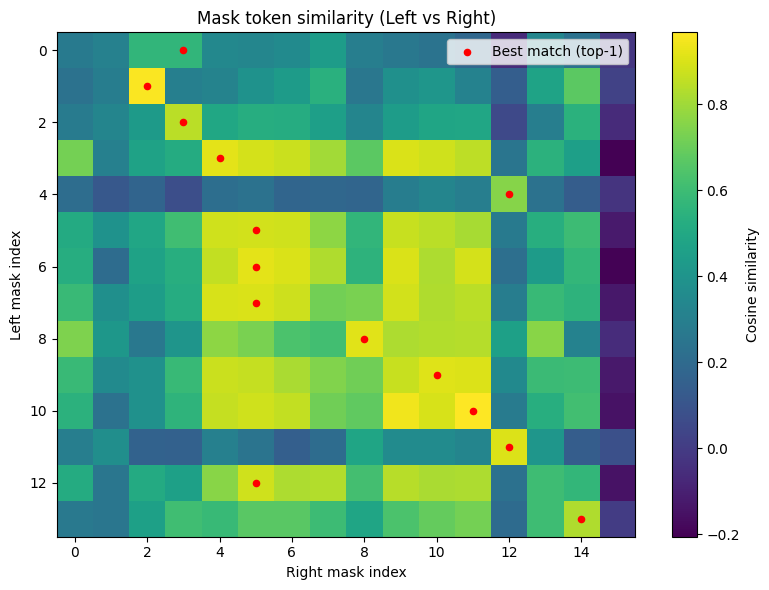

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Heatmap of cosine similarity (Left vs Right)
plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix, aspect='auto', cmap='viridis')
plt.colorbar(label='Cosine similarity')
plt.xlabel('Right mask index')
plt.ylabel('Left mask index')
plt.title('Mask token similarity (Left vs Right)')

# Overlay best matches per left mask (top-1)
y = np.arange(similarity_matrix.shape[0])
x = top_indices[:, 0]
plt.scatter(x, y, s=20, c='red', label='Best match (top-1)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Left left comparison

In [7]:
bee1_left_path="/data/home/umang/big-bee/output_masks/UCSB-IZC00055302_L/out.ome_mask_tokens.npy"
segmented_objects_bee1_left= np.load(bee1_left_path)
print(segmented_objects_bee1_left.shape)

(17, 1024)


In [8]:
bee2_left_path = "/data/home/umang/big-bee/output_masks/UCSB-IZC00055338_L/out.ome_mask_tokens.npy"
segmented_objects_bee2_left = np.load(bee2_left_path)
print(segmented_objects_bee2_left.shape)

(20, 1024)


In [9]:
# Find closest cosine similarity between segmented objects of left and right bees
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix2 = cosine_similarity(segmented_objects_bee1_left, segmented_objects_bee2_left)
top_k = 3
top_indices = np.argsort(similarity_matrix2, axis=1)[:, -top_k:][:, ::-1]
top_scores = np.take_along_axis(similarity_matrix2, top_indices, axis=1)
for i in range(similarity_matrix2.shape[0]):
    pairs = ", ".join([f"{idx} ({score:.4f})" for idx, score in zip(top_indices[i], top_scores[i])])
    print(f"Left1 {i} -> Top {top_k} Left2: {pairs}")

Left1 0 -> Top 3 Left2: 0 (0.6206), 15 (0.4189), 19 (0.3972)
Left1 1 -> Top 3 Left2: 1 (0.7281), 10 (0.6797), 3 (0.6769)
Left1 2 -> Top 3 Left2: 14 (0.8348), 2 (0.8323), 7 (0.3592)
Left1 3 -> Top 3 Left2: 13 (0.6534), 5 (0.6237), 10 (0.6105)
Left1 4 -> Top 3 Left2: 3 (0.7470), 10 (0.6808), 9 (0.6789)
Left1 5 -> Top 3 Left2: 3 (0.7565), 9 (0.6945), 6 (0.6645)
Left1 6 -> Top 3 Left2: 9 (0.7210), 3 (0.6479), 10 (0.6285)
Left1 7 -> Top 3 Left2: 8 (0.6062), 12 (0.5988), 13 (0.5588)
Left1 8 -> Top 3 Left2: 6 (0.6676), 10 (0.6317), 3 (0.6294)
Left1 9 -> Top 3 Left2: 15 (0.4705), 0 (0.4562), 19 (0.4194)
Left1 10 -> Top 3 Left2: 1 (0.7928), 3 (0.5690), 10 (0.5682)
Left1 11 -> Top 3 Left2: 1 (0.7088), 11 (0.5369), 3 (0.5067)
Left1 12 -> Top 3 Left2: 3 (0.6963), 9 (0.6885), 6 (0.6764)
Left1 13 -> Top 3 Left2: 7 (0.7049), 9 (0.6087), 3 (0.5549)
Left1 14 -> Top 3 Left2: 12 (0.6206), 13 (0.6180), 6 (0.5637)
Left1 15 -> Top 3 Left2: 16 (0.6331), 18 (0.5542), 5 (0.5090)
Left1 16 -> Top 3 Left2: 12 (0.

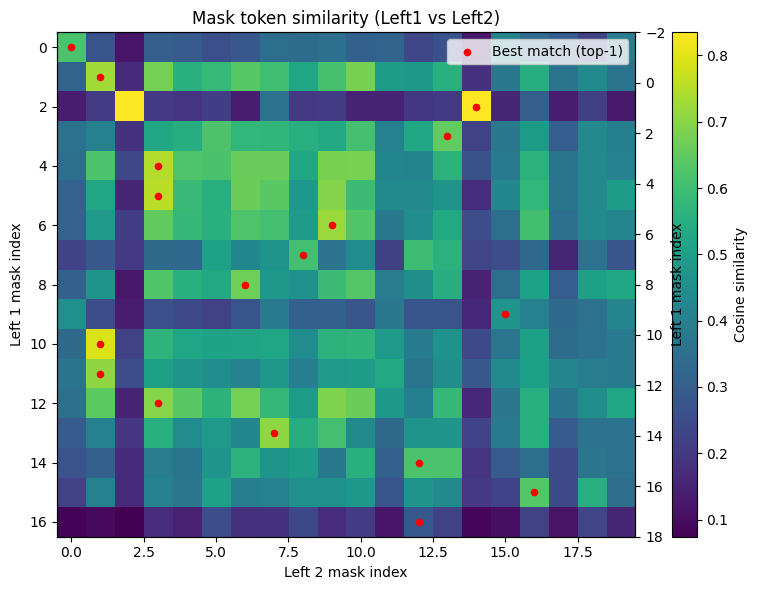

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Heatmap of cosine similarity (Left1 vs Left2)
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarity_matrix2, aspect='auto', cmap='viridis')
fig.colorbar(im, ax=ax, label='Cosine similarity')
ax.set_xlabel('Left 2 mask index')
ax.set_ylabel('Left 1 mask index')
ax.set_title('Mask token similarity (Left1 vs Left2)')

# Overlay best matches per left1 mask (top-1)
y = np.arange(similarity_matrix2.shape[0])
x = top_indices[:, 0]
ax.scatter(x, y, s=20, c='red', label='Best match (top-1)')
ax.legend(loc='upper right')

# Right y-axis mirror
ax_right = ax.twinx()
ax_right.set_ylim(ax.get_ylim())
ax_right.set_yticks(ax.get_yticks())
ax_right.set_ylabel('Left 1 mask index')

plt.tight_layout()
plt.show()

**Plot explanation:** This histogram shows how often each best circular shift (in groups of 4 dims) appears when matching Left1 masks to their closest Left2 masks. A sharp peak means a consistent latent phase shift; a flat or multi-peak distribution suggests no stable rotational alignment in this latent grouping.

# DINOv2 FEATURES

In [74]:
import sys
sys.path.append('/data/home/umang/big-bee/segment-anything')
sys.path.append('/data/home/umang/big-bee/dinov2-main')

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# Import SAM
from segment_anything import sam_model_registry, SamPredictor

# Import DINOv2
import dinov2.hub.backbones as dinov2_backbones

In [75]:
# Load SAM model
sam_checkpoint = "/data/home/umang/big-bee/instance-detection_current/configs/sam_vit_l_0b3195.pth"
model_type = "vit_l"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device='cuda' if torch.cuda.is_available() else 'cpu')
predictor = SamPredictor(sam)

# Load DINOv2 large
dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_model.to(device='cuda' if torch.cuda.is_available() else 'cpu')
dinov2_model.eval()

Using cache found in /data/home/umang/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1024,), eps=1e-06, element

In [76]:
# Load automatic mask generation
from segment_anything import SamAutomaticMaskGenerator
mask_generator = SamAutomaticMaskGenerator(sam)

## Left image

In [77]:
# Function to get cutout
def get_cutout(image_np, mask):
    import cv2
    mask_np = mask['segmentation'].astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    mask_clean = cv2.morphologyEx(mask_np, cv2.MORPH_OPEN, kernel)
    masked_image = image_np * mask_clean[:, :, None]
    y_indices, x_indices = np.where(mask_clean)
    if len(y_indices) == 0 or len(x_indices) == 0:
        return None
    y_min, y_max = y_indices.min(), y_indices.max()
    x_min, x_max = x_indices.min(), x_indices.max()
    cutout = masked_image[y_min:y_max+1, x_min:x_max+1]

    if np.count_nonzero(cutout) < 0.05 * cutout.size:
        return None
    
    # Remove extremely small cutouts (e.g. less than 20x20 pixels)
    if cutout.shape[0] < 20 or cutout.shape[1] < 20:
        return None
    return cutout

def mask_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0.0
    return intersection / union

def process_masks(image_np, masks, image_name):
    import os
    cutouts_dir = f"/data/home/umang/big-bee/cutouts/{image_name}"
    os.makedirs(cutouts_dir, exist_ok=True)
    embeddings = []
    valid_masks = []
    cutout_count = 0
    iou_threshold = 0.85
    unique_masks = []
    for mask in masks:
        seg = mask['segmentation']
        is_duplicate = False
        for um in unique_masks:
            if mask_iou(seg, um['segmentation']) > iou_threshold:
                is_duplicate = True
                break
        if not is_duplicate:
            unique_masks.append(mask)
    for mask in unique_masks:
        area = np.sum(mask['segmentation'])
        if area < 1000:
            continue
        cutout = get_cutout(image_np, mask)
        if cutout is None or cutout.size == 0:
            continue
        if np.count_nonzero(cutout) < 0.05 * cutout.size:
            continue
        cutout_pil = Image.fromarray(cutout.astype('uint8'))
        cutout_path = os.path.join(cutouts_dir, f"cutout_{cutout_count}.png")
        cutout_pil.save(cutout_path)
        cutout_resized = cutout_pil.resize((224, 224))
        cutout_tensor = torch.from_numpy(np.array(cutout_resized)).permute(2, 0, 1).float() / 255.0
        cutout_tensor = cutout_tensor.unsqueeze(0).to(device='cuda' if torch.cuda.is_available() else 'cpu')
        with torch.no_grad():
            embedding = dinov2_model(cutout_tensor).squeeze().cpu().numpy()
        embeddings.append(embedding)
        valid_masks.append(mask)
        cutout_count += 1
    embeddings = np.array(embeddings)
    print(f"Number of valid embeddings: {len(embeddings)}")
    print(f"Embedding shape: {embeddings.shape}")
    print(f"Cutouts saved in {cutouts_dir}")
    return embeddings

In [78]:
# Process masks and save cutouts/embeddings for both images
image1_path = "/data/home/umang/big-bee/data/cropped_rotated/UCSB-IZC00055338_L_cropped_rotated_flipped_v_flipped_h.png"
image1_name = os.path.splitext(os.path.basename(image1_path))[0]
image1 = Image.open(image1_path).convert("RGB")
image1_np = np.array(image1)
    
# Set image for SAM
predictor.set_image(image1_np)

# For demonstration, let's assume we have prompts or automatic segmentation
# SAM can do automatic segmentation with masks, but typically needs prompts.
# For bee wings, perhaps use automatic mask generation.

masks = mask_generator.generate(image1_np)

print(f"Number of masks: {len(masks)}")

Number of masks: 26


In [79]:
# Process masks and get embeddings
image1_name = os.path.splitext(os.path.basename(image1_path))[0]
embeddings1 = process_masks(image1_np, masks, image1_name)

Number of valid embeddings: 17
Embedding shape: (17, 1024)
Cutouts saved in /data/home/umang/big-bee/cutouts/UCSB-IZC00055338_L_cropped_rotated_flipped_v_flipped_h


In [80]:
# Save embeddings
output_path = f"/data/home/umang/big-bee/output_masks/{image1_name}/out.ome_mask_tokens.npy"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
np.save(output_path, embeddings1)
print(f"Embeddings saved to {output_path}")

Embeddings saved to /data/home/umang/big-bee/output_masks/UCSB-IZC00055338_L_cropped_rotated_flipped_v_flipped_h/out.ome_mask_tokens.npy


## Right wing

In [81]:
# Load an image
image2_path = "/data/home/umang/big-bee/data/cropped_rotated/UCSB-IZC00055338_R_cropped_rotated.png"
image2 = Image.open(image2_path).convert("RGB")
image2_np = np.array(image2)
    
# Set image for SAM
predictor.set_image(image2_np)

# For demonstration, let's assume we have prompts or automatic segmentation
# SAM can do automatic segmentation with masks, but typically needs prompts.
# For bee wings, perhaps use automatic mask generation.

masks = mask_generator.generate(image2_np)

print(f"Number of masks: {len(masks)}")

Number of masks: 32


In [82]:
# Process masks and get embeddings
image2_name = os.path.splitext(os.path.basename(image2_path))[0]
embeddings2 = process_masks(image2_np, masks, image2_name)

Number of valid embeddings: 19
Embedding shape: (19, 1024)
Cutouts saved in /data/home/umang/big-bee/cutouts/UCSB-IZC00055338_R_cropped_rotated


In [83]:
# Save embeddings
output_path = f"/data/home/umang/big-bee/output_masks/{image2_name}/out.ome_mask_tokens.npy"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
np.save(output_path, embeddings2)
print(f"Embeddings saved to {output_path}")

Embeddings saved to /data/home/umang/big-bee/output_masks/UCSB-IZC00055338_R_cropped_rotated/out.ome_mask_tokens.npy


In [86]:
#Compare embeddings between the two images (e.g. using cosine similarity) to find matching segmented objects.

# Load embeddings
embeddings1 = np.load(f"/data/home/umang/big-bee/output_masks/{image1_name}/out.ome_mask_tokens.npy")
embeddings2 = np.load(f"/data/home/umang/big-bee/output_masks/{image2_name}/out.ome_mask_tokens.npy")

# Compute cosine similarity
similarity_matrix = cosine_similarity(embeddings1, embeddings2)
# PRINT TOP-3 MATCHES with scores
top_k = 3
top_indices = np.argsort(similarity_matrix, axis=1)[:, -top_k:][:, ::-1]
top_scores = np.take_along_axis(similarity_matrix, top_indices, axis=1)
for i in range(similarity_matrix.shape[0]):
    pairs = ", ".join([f"{idx} ({score:.4f})" for idx, score in zip(top_indices[i], top_scores[i])])
    print(f"Left {i} -> Top {top_k} Right: {pairs}")


Left 0 -> Top 3 Right: 3 (0.7636), 4 (0.7446), 0 (0.6804)
Left 1 -> Top 3 Right: 8 (0.8598), 15 (0.8192), 0 (0.6627)
Left 2 -> Top 3 Right: 5 (0.8219), 4 (0.7206), 3 (0.6705)
Left 3 -> Top 3 Right: 4 (0.8778), 2 (0.7352), 3 (0.7272)
Left 4 -> Top 3 Right: 7 (0.7242), 13 (0.6627), 2 (0.6469)
Left 5 -> Top 3 Right: 1 (0.8311), 4 (0.6674), 2 (0.6112)
Left 6 -> Top 3 Right: 9 (0.8544), 4 (0.8036), 2 (0.7578)
Left 7 -> Top 3 Right: 10 (0.6615), 6 (0.5937), 13 (0.5118)
Left 8 -> Top 3 Right: 9 (0.6727), 2 (0.5895), 16 (0.5301)
Left 9 -> Top 3 Right: 2 (0.6658), 4 (0.6582), 3 (0.6075)
Left 10 -> Top 3 Right: 6 (0.7628), 1 (0.6435), 4 (0.6336)
Left 11 -> Top 3 Right: 10 (0.5727), 13 (0.4748), 17 (0.4311)
Left 12 -> Top 3 Right: 11 (0.7121), 13 (0.6005), 16 (0.5950)
Left 13 -> Top 3 Right: 18 (0.4974), 10 (0.4928), 13 (0.4427)
Left 14 -> Top 3 Right: 12 (0.7175), 16 (0.6403), 13 (0.6343)
Left 15 -> Top 3 Right: 17 (0.7615), 13 (0.5010), 16 (0.4903)
Left 16 -> Top 3 Right: 6 (0.4034), 1 (0.3536)

In [ ]:
# Wrong matches:
# left8
# left16

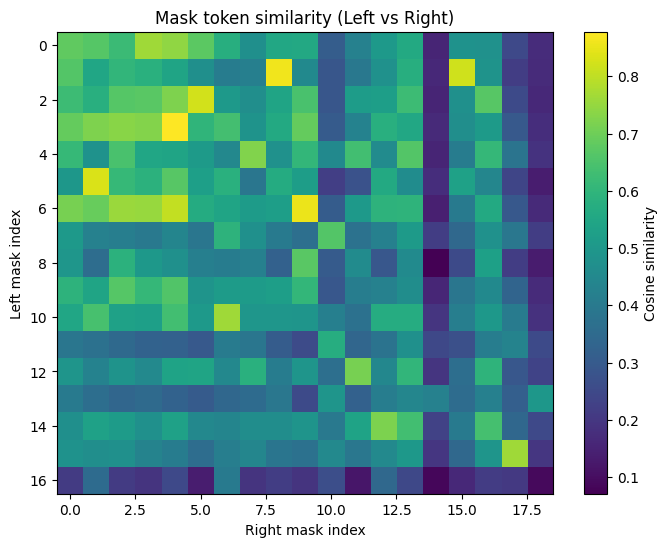

In [90]:
# plot heatmap of similarity matrix
plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix, aspect='auto', cmap='viridis')
plt.colorbar(label='Cosine similarity')
plt.xlabel('Right mask index')
plt.ylabel('Left mask index')
plt.title('Mask token similarity (Left vs Right)')
plt.show()
